In [113]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import infercnvpy as cnv
import matplotlib

import sys
sys.path.append("../..")
import insitucnv as icv

### Load functions

In [114]:
import numpy as np

def compute_cnv_metrics(adata):
    """
    Compute CNV performance metrics based on ground truth and CNV values.
    
    Parameters:
    - adata: AnnData object containing CNV ground truth in `adata.layers['CNV_GT']`
             and CNV values in `adata.layers['gene_values_cnv']`
    
    Returns:
    - Dictionary with F1 scores for overall CNV detection, CNV gain, and CNV loss.
    """
    ground_truth = adata.layers['CNV_GT']
    cnv_values = adata.layers["gene_values_cnv"]

    # Extract CNV scores based on ground truth
    cnv_score_in_gains = [x for x in cnv_values[ground_truth == 1] if str(x) != 'nan']
    cnv_score_in_losses = [x for x in cnv_values[ground_truth == -1] if str(x) != 'nan']
    cnv_score_in_neutrals = [x for x in cnv_values[ground_truth == 0] if str(x) != 'nan']
    cnv_score_in_cnv = [x for x in cnv_values[ground_truth != 0] if str(x) != 'nan']

    # Compute true and false classifications
    try:
        true_gains = len([e for e in cnv_score_in_gains if e > 0]) / len(cnv_score_in_gains)
        true_losses = len([e for e in cnv_score_in_losses if e < 0]) / len(cnv_score_in_losses)
        true_neutrals = np.sum(np.abs(cnv_score_in_neutrals) == 0) / len(cnv_score_in_neutrals)
        true_cnv = np.sum(np.abs(cnv_score_in_cnv) != 0) / len(cnv_score_in_cnv)
        false_neutrals = 1 - true_neutrals
        false_cnv = 1 - true_cnv
        # Compute performance metrics
        results_all = icv.tl.compute_performance_metrics(true_cnv, false_neutrals, true_neutrals, false_cnv)
        results_gain = icv.tl.compute_performance_metrics(true_gains, false_neutrals, true_neutrals, 1 - true_gains)
        results_loss = icv.tl.compute_performance_metrics(true_losses, false_neutrals, true_neutrals, 1 - true_losses)
        return {
        "All": results_all['F1 Score'],
        "Gain": results_gain['F1 Score'],
        "Loss": results_loss['F1 Score']}
    except:
        return {
        "All": np.nan,
        "Gain": np.nan,
        "Loss": np.nan}

def compute_cnv_auc(adata):
    """
    Compute ROC AUC and PR AUC for CNV gains and losses.

    Parameters:
    - adata: AnnData object containing CNV ground truth in `adata.layers['CNV_GT']`
             and CNV inferred scores in `adata.layers['gene_values_cnv']`

    Returns:
    - Dictionary with ROC AUC and PR AUC scores for CNV gains and losses.
    """
    ground_truth = adata.layers['CNV_GT']
    cnv_values = adata.layers["gene_values_cnv"]

    # Flatten arrays for processing
    simulated = ground_truth.flatten()  
    inferred_scores = cnv_values.flatten()  

    # Remove NaN values
    filter_nan = np.array([str(x) != 'nan' for x in inferred_scores])
    simulated = simulated[filter_nan]
    inferred_scores = inferred_scores[filter_nan]

    # Compute AUC for gains (1) and losses (-1)
    roc_auc_gains, pr_auc_gains = icv.tl.compute_auc(simulated, inferred_scores, 1)
    roc_auc_losses, pr_auc_losses = icv.tl.compute_auc(simulated, inferred_scores, -1)

    return {"ROC AUC (Gains)": roc_auc_gains,"PR AUC (Gains)": pr_auc_gains,
        "ROC AUC (Losses)": roc_auc_losses,"PR AUC (Losses)": pr_auc_losses}


# Load datasets

In [115]:
path_simulation='/media/external/test/augusta/insituCNV/data/simulated_CNV_data/technical_limiting_conditions'

In [116]:
files=os.listdir(path_simulation)
processed_datasets=[f  for f in files if '_CNVinf' in f]
processed_datasets_counts=[f  for f in processed_datasets if 'counts' in f]
processed_datasets_cg=[f  for f in processed_datasets_counts if 'genes' in f]

## Quantify on different counts

We aim to compare the output of CNV prediction on simulated datasets, first varying the number of counts captured on each cell

In [19]:
file='CNV_simulated_subsampled_counts_1_CNVinf.h5ad'

In [120]:
alltags=[]
for file in tqdm(processed_datasets_cg):
    print(file)
    experiment_tag=file.split('_')[2]
    counts=file.split('_')[5]
    genes=file.split('_')[7]
    alltags.append(experiment_tag)

100%|█████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 126774.90it/s]

CNV_simulation_02_subsampled_counts_100_genes_all_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_70_genes_all_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_70_genes_20000_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_50_genes_all_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_50_genes_15000_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_50_genes_5000_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_10_genes_1000_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_5_genes_all_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_5_genes_20000_CNVinf.h5ad
CNV_simulation_02_subsampled_counts_5_genes_15000_CNVinf.h5ad
CNV_simulation_01_subsampled_counts_70_genes_all_CNVinf.h5ad
CNV_simulation_01_subsampled_counts_70_genes_20000_CNVinf.h5ad
CNV_simulation_01_subsampled_counts_70_genes_15000_CNVinf.h5ad
CNV_simulation_01_subsampled_counts_70_genes_10000_CNVinf.h5ad
CNV_simulation_01_subsampled_counts_70_genes_5000_CNVinf.h5ad
CNV_simulation_01_subsampled_counts_70_genes_1000_CNVinf.h5ad
CNV_simu

In [121]:
from tqdm import tqdm
results=pd.DataFrame(columns=['type_of_sampling','experiment','n_genes','n_counts','mean_countsxcell','nmi','ari','F1score_all','F1score_gain',
                      'F1score_loss','AUC_loss','PR_gains','AUC_loss','PR_loss'])
i=0
for file in tqdm(processed_datasets_cg):
    print(file)
    experiment_tag=file.split('_')[2]
    counts=file.split('_')[5]
    genes=file.split('_')[7]
    adata=sc.read(os.path.join(path_simulation,file))
    # clustering similarity metrics
    comp_key=[a for a in adata.obs.columns if 'cnv_leiden_res' in a]
    ari = icv.tl.compute_ari(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    nmi = icv.tl.compute_nmi(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    # CNV predictability metrics
    try:
        F1score_dict=compute_cnv_metrics(adata)
        ROC_PR_dict=compute_cnv_auc(adata)
        results.loc[i,'F1score_all']=F1score_dict['All']
        results.loc[i,'F1score_gain']=F1score_dict['Gain']
        results.loc[i,'F1score_loss']=F1score_dict['Loss']
        results.loc[i,'AUC_gains']=ROC_PR_dict['ROC AUC (Gains)']
        results.loc[i,'PR_gains']=ROC_PR_dict['PR AUC (Gains)']
        results.loc[i,'AUC_loss']=ROC_PR_dict['ROC AUC (Losses)']
        results.loc[i,'PR_loss']=ROC_PR_dict['PR AUC (Losses)']
    except: 
        print('not possible')
        ## formatting them as CNVs
    results.loc[i,'type_of_sampling']=type_of_subsampling
    results.loc[i,'n_genes']=genes
    results.loc[i,'n_subsample']=counts
    results.loc[i,'mean_countsxcell']=np.mean(np.sum(adata.layers['CNV_simulated_raw'].todense(),axis=1)) # confirm with augusta
    results.loc[i,'ari']=ari
    results.loc[i,'nmi']=nmi
    results.loc[i,'experiment']=experiment_tag
    i=i+1

  0%|                                                                                           | 0/189 [00:00<?, ?it/s]

CNV_simulation_02_subsampled_counts_100_genes_all_CNVinf.h5ad


  1%|▍                                                                                | 1/189 [01:27<4:34:46, 87.69s/it]

CNV_simulation_02_subsampled_counts_70_genes_all_CNVinf.h5ad


  1%|▊                                                                                | 2/189 [02:51<4:26:15, 85.43s/it]

CNV_simulation_02_subsampled_counts_70_genes_20000_CNVinf.h5ad


  2%|█▎                                                                               | 3/189 [03:58<3:59:06, 77.13s/it]

CNV_simulation_02_subsampled_counts_50_genes_all_CNVinf.h5ad


  2%|█▋                                                                               | 4/189 [05:23<4:06:27, 79.93s/it]

CNV_simulation_02_subsampled_counts_50_genes_15000_CNVinf.h5ad


  3%|██▏                                                                              | 5/189 [06:14<3:33:43, 69.69s/it]

CNV_simulation_02_subsampled_counts_50_genes_5000_CNVinf.h5ad


  3%|██▌                                                                              | 6/189 [06:30<2:36:49, 51.42s/it]

CNV_simulation_02_subsampled_counts_10_genes_1000_CNVinf.h5ad


  4%|███                                                                              | 7/189 [06:33<1:48:14, 35.69s/it]

CNV_simulation_02_subsampled_counts_5_genes_all_CNVinf.h5ad


  4%|███▍                                                                             | 8/189 [07:58<2:34:16, 51.14s/it]

CNV_simulation_02_subsampled_counts_5_genes_20000_CNVinf.h5ad


  5%|███▊                                                                             | 9/189 [09:02<2:45:37, 55.21s/it]

CNV_simulation_02_subsampled_counts_5_genes_15000_CNVinf.h5ad


  5%|████▏                                                                           | 10/189 [09:51<2:39:24, 53.43s/it]

CNV_simulation_01_subsampled_counts_70_genes_all_CNVinf.h5ad


  6%|████▋                                                                           | 11/189 [11:20<3:10:38, 64.26s/it]

CNV_simulation_01_subsampled_counts_70_genes_20000_CNVinf.h5ad


  6%|█████                                                                           | 12/189 [12:28<3:12:53, 65.39s/it]

CNV_simulation_01_subsampled_counts_70_genes_15000_CNVinf.h5ad


  7%|█████▌                                                                          | 13/189 [13:17<2:57:28, 60.50s/it]

CNV_simulation_01_subsampled_counts_70_genes_10000_CNVinf.h5ad


  7%|█████▉                                                                          | 14/189 [13:52<2:33:56, 52.78s/it]

CNV_simulation_01_subsampled_counts_70_genes_5000_CNVinf.h5ad


  8%|██████▎                                                                         | 15/189 [14:10<2:02:33, 42.26s/it]

CNV_simulation_01_subsampled_counts_70_genes_1000_CNVinf.h5ad


  8%|██████▊                                                                         | 16/189 [14:13<1:28:01, 30.53s/it]

CNV_simulation_01_subsampled_counts_70_genes_500_CNVinf.h5ad


  9%|███████▏                                                                        | 17/189 [14:15<1:02:38, 21.85s/it]

not possible
CNV_simulation_01_subsampled_counts_50_genes_all_CNVinf.h5ad


 10%|███████▌                                                                        | 18/189 [15:44<2:00:04, 42.13s/it]

CNV_simulation_01_subsampled_counts_50_genes_20000_CNVinf.h5ad


 10%|████████                                                                        | 19/189 [16:47<2:16:49, 48.29s/it]

CNV_simulation_01_subsampled_counts_50_genes_15000_CNVinf.h5ad


 11%|████████▍                                                                       | 20/189 [17:39<2:19:24, 49.49s/it]

CNV_simulation_01_subsampled_counts_50_genes_10000_CNVinf.h5ad


 11%|████████▉                                                                       | 21/189 [18:10<2:02:29, 43.75s/it]

CNV_simulation_01_subsampled_counts_50_genes_5000_CNVinf.h5ad


 12%|█████████▎                                                                      | 22/189 [18:25<1:38:02, 35.23s/it]

CNV_simulation_01_subsampled_counts_50_genes_1000_CNVinf.h5ad


 12%|█████████▋                                                                      | 23/189 [18:28<1:10:54, 25.63s/it]

CNV_simulation_01_subsampled_counts_50_genes_500_CNVinf.h5ad


 13%|██████████▍                                                                       | 24/189 [18:32<52:50, 19.22s/it]

not possible
CNV_simulation_01_subsampled_counts_20_genes_all_CNVinf.h5ad


 13%|██████████▌                                                                     | 25/189 [19:53<1:42:38, 37.55s/it]

CNV_simulation_01_subsampled_counts_20_genes_15000_CNVinf.h5ad


 14%|███████████                                                                     | 26/189 [20:41<1:50:37, 40.72s/it]

CNV_simulation_01_subsampled_counts_20_genes_5000_CNVinf.h5ad


 14%|███████████▍                                                                    | 27/189 [20:58<1:30:31, 33.52s/it]

CNV_simulation_01_subsampled_counts_10_genes_10000_CNVinf.h5ad


 15%|███████████▊                                                                    | 28/189 [21:28<1:27:05, 32.46s/it]

CNV_simulation_01_subsampled_counts_10_genes_1000_CNVinf.h5ad


 15%|████████████▎                                                                   | 29/189 [21:31<1:03:15, 23.72s/it]

CNV_simulation_01_subsampled_counts_5_genes_5000_CNVinf.h5ad


 16%|█████████████                                                                     | 30/189 [21:46<56:21, 21.27s/it]

CNV_simulation_01_subsampled_counts_5_genes_500_CNVinf.h5ad


 16%|█████████████▍                                                                    | 31/189 [21:48<40:29, 15.38s/it]

not possible
CNV_simulation_01_subsampled_counts_3_genes_500_CNVinf.h5ad


 17%|█████████████▉                                                                    | 32/189 [21:50<29:24, 11.24s/it]

not possible
CNV_simulation_01_subsampled_counts_2_genes_1000_CNVinf.h5ad


 17%|██████████████▎                                                                   | 33/189 [21:53<23:02,  8.86s/it]

CNV_simulation_01_subsampled_counts_1_genes_20000_CNVinf.h5ad


 18%|██████████████▍                                                                 | 34/189 [22:56<1:04:57, 25.14s/it]

CNV_simulation_01_subsampled_counts_1_genes_15000_CNVinf.h5ad


 19%|██████████████▊                                                                 | 35/189 [23:45<1:22:35, 32.18s/it]

CNV_simulation_01_subsampled_counts_1_genes_500_CNVinf.h5ad


 19%|███████████████▌                                                                  | 36/189 [23:46<58:34, 22.97s/it]

not possible
CNV_simulation_01_subsampled_counts_100_genes_all_CNVinf.h5ad


 20%|███████████████▋                                                                | 37/189 [25:11<1:45:30, 41.64s/it]

CNV_simulation_01_subsampled_counts_100_genes_20000_CNVinf.h5ad


 20%|████████████████                                                                | 38/189 [26:18<2:03:50, 49.21s/it]

CNV_simulation_01_subsampled_counts_100_genes_15000_CNVinf.h5ad


 21%|████████████████▌                                                               | 39/189 [27:08<2:03:39, 49.46s/it]

CNV_simulation_01_subsampled_counts_100_genes_10000_CNVinf.h5ad


 21%|████████████████▉                                                               | 40/189 [27:40<1:49:51, 44.24s/it]

CNV_simulation_01_subsampled_counts_100_genes_5000_CNVinf.h5ad


 22%|█████████████████▎                                                              | 41/189 [27:57<1:28:39, 35.94s/it]

CNV_simulation_01_subsampled_counts_100_genes_1000_CNVinf.h5ad


 22%|█████████████████▊                                                              | 42/189 [28:00<1:04:12, 26.20s/it]

CNV_simulation_01_subsampled_counts_100_genes_500_CNVinf.h5ad


 23%|██████████████████▋                                                               | 43/189 [28:02<45:49, 18.84s/it]

not possible
CNV_simulation_02_subsampled_counts_5_genes_10000_CNVinf.h5ad


 23%|███████████████████                                                               | 44/189 [28:34<55:15, 22.86s/it]

CNV_simulation_02_subsampled_counts_100_genes_20000_CNVinf.h5ad


 24%|███████████████████                                                             | 45/189 [29:38<1:24:19, 35.14s/it]

CNV_simulation_02_subsampled_counts_100_genes_15000_CNVinf.h5ad


 24%|███████████████████▍                                                            | 46/189 [30:26<1:33:08, 39.08s/it]

CNV_simulation_02_subsampled_counts_100_genes_10000_CNVinf.h5ad


 25%|███████████████████▉                                                            | 47/189 [30:57<1:26:12, 36.42s/it]

CNV_simulation_02_subsampled_counts_100_genes_5000_CNVinf.h5ad


 25%|████████████████████▎                                                           | 48/189 [31:12<1:11:00, 30.22s/it]

CNV_simulation_02_subsampled_counts_100_genes_1000_CNVinf.h5ad


 26%|█████████████████████▎                                                            | 49/189 [31:15<51:22, 22.02s/it]

CNV_simulation_02_subsampled_counts_100_genes_500_CNVinf.h5ad


 26%|█████████████████████▋                                                            | 50/189 [31:17<37:05, 16.01s/it]

CNV_simulation_02_subsampled_counts_70_genes_15000_CNVinf.h5ad


 27%|██████████████████████▏                                                           | 51/189 [32:05<58:30, 25.44s/it]

CNV_simulation_02_subsampled_counts_70_genes_10000_CNVinf.h5ad


 28%|██████████████████████                                                          | 52/189 [32:35<1:01:22, 26.88s/it]

CNV_simulation_02_subsampled_counts_70_genes_5000_CNVinf.h5ad


 28%|██████████████████████▉                                                           | 53/189 [32:51<53:34, 23.63s/it]

CNV_simulation_02_subsampled_counts_70_genes_1000_CNVinf.h5ad


 29%|███████████████████████▍                                                          | 54/189 [32:54<39:16, 17.45s/it]

CNV_simulation_02_subsampled_counts_70_genes_500_CNVinf.h5ad


 29%|███████████████████████▊                                                          | 55/189 [32:56<28:33, 12.78s/it]

CNV_simulation_02_subsampled_counts_50_genes_20000_CNVinf.h5ad


 30%|███████████████████████▋                                                        | 56/189 [33:58<1:01:19, 27.67s/it]

CNV_simulation_02_subsampled_counts_50_genes_10000_CNVinf.h5ad


 30%|████████████████████████▏                                                       | 57/189 [34:28<1:02:04, 28.22s/it]

CNV_simulation_02_subsampled_counts_50_genes_1000_CNVinf.h5ad


 31%|█████████████████████████▏                                                        | 58/189 [34:31<45:08, 20.68s/it]

CNV_simulation_02_subsampled_counts_50_genes_500_CNVinf.h5ad


 31%|█████████████████████████▌                                                        | 59/189 [34:33<32:34, 15.04s/it]

CNV_simulation_02_subsampled_counts_20_genes_all_CNVinf.h5ad


 32%|█████████████████████████▍                                                      | 60/189 [35:53<1:14:07, 34.48s/it]

CNV_simulation_02_subsampled_counts_5_genes_5000_CNVinf.h5ad


 32%|█████████████████████████▊                                                      | 61/189 [36:08<1:01:13, 28.70s/it]

CNV_simulation_02_subsampled_counts_5_genes_1000_CNVinf.h5ad


 33%|██████████████████████████▉                                                       | 62/189 [36:11<44:28, 21.01s/it]

CNV_simulation_02_subsampled_counts_5_genes_500_CNVinf.h5ad


 33%|███████████████████████████▎                                                      | 63/189 [36:13<32:08, 15.30s/it]

CNV_simulation_02_subsampled_counts_3_genes_all_CNVinf.h5ad


 34%|███████████████████████████                                                     | 64/189 [37:34<1:13:00, 35.05s/it]

CNV_simulation_02_subsampled_counts_3_genes_20000_CNVinf.h5ad


 34%|███████████████████████████▌                                                    | 65/189 [38:37<1:30:02, 43.57s/it]

CNV_simulation_02_subsampled_counts_3_genes_15000_CNVinf.h5ad


 35%|███████████████████████████▉                                                    | 66/189 [39:27<1:32:44, 45.24s/it]

CNV_simulation_02_subsampled_counts_3_genes_10000_CNVinf.h5ad


 35%|████████████████████████████▎                                                   | 67/189 [39:59<1:24:10, 41.39s/it]

CNV_simulation_02_subsampled_counts_3_genes_5000_CNVinf.h5ad


 36%|████████████████████████████▊                                                   | 68/189 [40:15<1:07:48, 33.62s/it]

CNV_simulation_02_subsampled_counts_3_genes_1000_CNVinf.h5ad


 37%|█████████████████████████████▉                                                    | 69/189 [40:21<51:10, 25.59s/it]

CNV_simulation_02_subsampled_counts_2_genes_all_CNVinf.h5ad


 37%|█████████████████████████████▋                                                  | 70/189 [41:51<1:28:53, 44.82s/it]

CNV_simulation_02_subsampled_counts_2_genes_20000_CNVinf.h5ad


 38%|██████████████████████████████                                                  | 71/189 [42:56<1:39:51, 50.78s/it]

CNV_simulation_02_subsampled_counts_2_genes_15000_CNVinf.h5ad


 38%|██████████████████████████████▍                                                 | 72/189 [43:45<1:38:04, 50.29s/it]

CNV_simulation_02_subsampled_counts_2_genes_10000_CNVinf.h5ad


 39%|██████████████████████████████▉                                                 | 73/189 [44:15<1:25:45, 44.35s/it]

CNV_simulation_02_subsampled_counts_2_genes_5000_CNVinf.h5ad


 39%|███████████████████████████████▎                                                | 74/189 [44:31<1:08:44, 35.87s/it]

CNV_simulation_02_subsampled_counts_2_genes_1000_CNVinf.h5ad


 40%|████████████████████████████████▌                                                 | 75/189 [44:34<49:23, 25.99s/it]

CNV_simulation_02_subsampled_counts_2_genes_500_CNVinf.h5ad


 40%|████████████████████████████████▉                                                 | 76/189 [44:36<35:21, 18.78s/it]

CNV_simulation_02_subsampled_counts_1_genes_all_CNVinf.h5ad


 41%|████████████████████████████████▌                                               | 77/189 [46:01<1:11:57, 38.54s/it]

CNV_simulation_02_subsampled_counts_1_genes_20000_CNVinf.h5ad


 41%|█████████████████████████████████                                               | 78/189 [47:06<1:25:46, 46.37s/it]

CNV_simulation_02_subsampled_counts_1_genes_15000_CNVinf.h5ad


 42%|█████████████████████████████████▍                                              | 79/189 [47:55<1:26:44, 47.31s/it]

CNV_simulation_02_subsampled_counts_1_genes_10000_CNVinf.h5ad


 42%|█████████████████████████████████▊                                              | 80/189 [48:28<1:17:58, 42.93s/it]

CNV_simulation_02_subsampled_counts_1_genes_5000_CNVinf.h5ad


 43%|██████████████████████████████████▎                                             | 81/189 [48:44<1:02:43, 34.85s/it]

CNV_simulation_02_subsampled_counts_1_genes_1000_CNVinf.h5ad


 43%|███████████████████████████████████▌                                              | 82/189 [48:47<45:09, 25.33s/it]

CNV_simulation_02_subsampled_counts_1_genes_500_CNVinf.h5ad


 44%|████████████████████████████████████                                              | 83/189 [48:49<32:23, 18.33s/it]

CNV_simulation_03_subsampled_counts_100_genes_15000_CNVinf.h5ad


 44%|████████████████████████████████████▍                                             | 84/189 [49:37<47:30, 27.15s/it]

CNV_simulation_03_subsampled_counts_100_genes_500_CNVinf.h5ad


 45%|████████████████████████████████████▉                                             | 85/189 [49:39<34:06, 19.68s/it]

CNV_simulation_03_subsampled_counts_50_genes_20000_CNVinf.h5ad


 46%|█████████████████████████████████████▎                                            | 86/189 [50:43<56:26, 32.88s/it]

CNV_simulation_03_subsampled_counts_50_genes_5000_CNVinf.h5ad


 46%|█████████████████████████████████████▋                                            | 87/189 [50:58<46:52, 27.58s/it]

CNV_simulation_03_subsampled_counts_20_genes_all_CNVinf.h5ad


 47%|█████████████████████████████████████▏                                          | 88/189 [52:19<1:13:20, 43.57s/it]

CNV_simulation_03_subsampled_counts_20_genes_20000_CNVinf.h5ad


 47%|█████████████████████████████████████▋                                          | 89/189 [53:22<1:22:29, 49.49s/it]

CNV_simulation_03_subsampled_counts_20_genes_15000_CNVinf.h5ad


 48%|██████████████████████████████████████                                          | 90/189 [54:10<1:20:43, 48.93s/it]

CNV_simulation_01_subsampled_counts_20_genes_20000_CNVinf.h5ad


 48%|██████████████████████████████████████▌                                         | 91/189 [55:13<1:26:54, 53.21s/it]

CNV_simulation_01_subsampled_counts_20_genes_10000_CNVinf.h5ad


 49%|██████████████████████████████████████▉                                         | 92/189 [55:43<1:14:41, 46.20s/it]

CNV_simulation_01_subsampled_counts_20_genes_1000_CNVinf.h5ad


 49%|████████████████████████████████████████▎                                         | 93/189 [55:46<53:13, 33.26s/it]

CNV_simulation_01_subsampled_counts_20_genes_500_CNVinf.h5ad


 50%|████████████████████████████████████████▊                                         | 94/189 [55:47<37:29, 23.68s/it]

not possible
CNV_simulation_01_subsampled_counts_10_genes_all_CNVinf.h5ad


 50%|████████████████████████████████████████▏                                       | 95/189 [57:11<1:05:25, 41.76s/it]

CNV_simulation_01_subsampled_counts_10_genes_20000_CNVinf.h5ad


 51%|████████████████████████████████████████▋                                       | 96/189 [58:35<1:24:29, 54.51s/it]

CNV_simulation_01_subsampled_counts_10_genes_15000_CNVinf.h5ad


 51%|█████████████████████████████████████████                                       | 97/189 [59:32<1:24:49, 55.32s/it]

CNV_simulation_01_subsampled_counts_10_genes_5000_CNVinf.h5ad


 52%|█████████████████████████████████████████▍                                      | 98/189 [59:51<1:07:06, 44.25s/it]

CNV_simulation_01_subsampled_counts_10_genes_500_CNVinf.h5ad


 52%|██████████████████████████████████████████▉                                       | 99/189 [59:52<47:00, 31.34s/it]

not possible
CNV_simulation_01_subsampled_counts_5_genes_all_CNVinf.h5ad


 53%|████████████████████████████████████████▋                                    | 100/189 [1:01:27<1:14:37, 50.31s/it]

CNV_simulation_01_subsampled_counts_5_genes_20000_CNVinf.h5ad


 53%|█████████████████████████████████████████▏                                   | 101/189 [1:03:04<1:34:27, 64.40s/it]

CNV_simulation_01_subsampled_counts_5_genes_15000_CNVinf.h5ad


 54%|█████████████████████████████████████████▌                                   | 102/189 [1:03:59<1:29:30, 61.73s/it]

CNV_simulation_01_subsampled_counts_5_genes_10000_CNVinf.h5ad


 54%|█████████████████████████████████████████▉                                   | 103/189 [1:04:58<1:27:08, 60.79s/it]

CNV_simulation_01_subsampled_counts_5_genes_1000_CNVinf.h5ad


 55%|██████████████████████████████████████████▎                                  | 104/189 [1:05:06<1:03:29, 44.82s/it]

CNV_simulation_01_subsampled_counts_3_genes_all_CNVinf.h5ad


 56%|██████████████████████████████████████████▊                                  | 105/189 [1:06:52<1:28:25, 63.17s/it]

CNV_simulation_01_subsampled_counts_3_genes_20000_CNVinf.h5ad


 56%|███████████████████████████████████████████▏                                 | 106/189 [1:08:06<1:32:08, 66.61s/it]

CNV_simulation_01_subsampled_counts_3_genes_15000_CNVinf.h5ad


 57%|███████████████████████████████████████████▌                                 | 107/189 [1:09:02<1:26:41, 63.43s/it]

CNV_simulation_01_subsampled_counts_3_genes_10000_CNVinf.h5ad


 57%|████████████████████████████████████████████                                 | 108/189 [1:09:46<1:17:36, 57.48s/it]

CNV_simulation_01_subsampled_counts_3_genes_5000_CNVinf.h5ad


 58%|████████████████████████████████████████████▍                                | 109/189 [1:10:21<1:07:44, 50.81s/it]

CNV_simulation_01_subsampled_counts_3_genes_1000_CNVinf.h5ad


 58%|█████████████████████████████████████████████▉                                 | 110/189 [1:10:29<49:49, 37.84s/it]

CNV_simulation_01_subsampled_counts_2_genes_all_CNVinf.h5ad


 59%|█████████████████████████████████████████████▏                               | 111/189 [1:12:36<1:24:05, 64.69s/it]

CNV_simulation_01_subsampled_counts_2_genes_20000_CNVinf.h5ad


 59%|█████████████████████████████████████████████▋                               | 112/189 [1:13:52<1:27:15, 67.99s/it]

CNV_simulation_01_subsampled_counts_2_genes_15000_CNVinf.h5ad


 60%|██████████████████████████████████████████████                               | 113/189 [1:14:57<1:25:02, 67.14s/it]

CNV_simulation_01_subsampled_counts_2_genes_10000_CNVinf.h5ad


 60%|██████████████████████████████████████████████▍                              | 114/189 [1:15:37<1:13:43, 58.99s/it]

CNV_simulation_01_subsampled_counts_2_genes_5000_CNVinf.h5ad


 61%|██████████████████████████████████████████████▊                              | 115/189 [1:16:08<1:02:23, 50.58s/it]

CNV_simulation_01_subsampled_counts_2_genes_500_CNVinf.h5ad


 61%|████████████████████████████████████████████████▍                              | 116/189 [1:16:10<43:49, 36.02s/it]

not possible
CNV_simulation_01_subsampled_counts_1_genes_all_CNVinf.h5ad


 62%|███████████████████████████████████████████████▋                             | 117/189 [1:17:53<1:07:29, 56.25s/it]

CNV_simulation_01_subsampled_counts_1_genes_10000_CNVinf.h5ad


 62%|████████████████████████████████████████████████                             | 118/189 [1:19:04<1:11:43, 60.61s/it]

CNV_simulation_01_subsampled_counts_1_genes_5000_CNVinf.h5ad


 63%|█████████████████████████████████████████████████▋                             | 119/189 [1:19:29<58:06, 49.80s/it]

CNV_simulation_01_subsampled_counts_1_genes_1000_CNVinf.h5ad


 63%|██████████████████████████████████████████████████▏                            | 120/189 [1:19:36<42:37, 37.06s/it]

CNV_simulation_02_subsampled_counts_20_genes_20000_CNVinf.h5ad


 64%|██████████████████████████████████████████████████▌                            | 121/189 [1:21:01<58:18, 51.45s/it]

CNV_simulation_02_subsampled_counts_20_genes_15000_CNVinf.h5ad


 65%|█████████████████████████████████████████████████▋                           | 122/189 [1:22:04<1:01:28, 55.05s/it]

CNV_simulation_02_subsampled_counts_20_genes_10000_CNVinf.h5ad


 65%|███████████████████████████████████████████████████▍                           | 123/189 [1:22:41<54:24, 49.46s/it]

CNV_simulation_02_subsampled_counts_20_genes_5000_CNVinf.h5ad


 66%|███████████████████████████████████████████████████▊                           | 124/189 [1:22:58<43:08, 39.83s/it]

CNV_simulation_02_subsampled_counts_20_genes_1000_CNVinf.h5ad


 66%|████████████████████████████████████████████████████▏                          | 125/189 [1:23:02<30:57, 29.02s/it]

CNV_simulation_02_subsampled_counts_20_genes_500_CNVinf.h5ad


 67%|████████████████████████████████████████████████████▋                          | 126/189 [1:23:04<22:00, 20.96s/it]

CNV_simulation_02_subsampled_counts_10_genes_all_CNVinf.h5ad


 67%|█████████████████████████████████████████████████████                          | 127/189 [1:24:58<50:26, 48.81s/it]

CNV_simulation_02_subsampled_counts_10_genes_20000_CNVinf.h5ad


 68%|████████████████████████████████████████████████████▏                        | 128/189 [1:26:27<1:02:01, 61.01s/it]

CNV_simulation_02_subsampled_counts_10_genes_15000_CNVinf.h5ad


 68%|█████████████████████████████████████████████████████▉                         | 129/189 [1:27:23<59:21, 59.36s/it]

CNV_simulation_02_subsampled_counts_10_genes_10000_CNVinf.h5ad


 69%|██████████████████████████████████████████████████████▎                        | 130/189 [1:28:00<51:45, 52.64s/it]

CNV_simulation_02_subsampled_counts_10_genes_5000_CNVinf.h5ad


 69%|██████████████████████████████████████████████████████▊                        | 131/189 [1:28:21<41:43, 43.16s/it]

CNV_simulation_02_subsampled_counts_10_genes_500_CNVinf.h5ad


 70%|███████████████████████████████████████████████████████▏                       | 132/189 [1:28:23<29:18, 30.84s/it]

CNV_simulation_02_subsampled_counts_3_genes_500_CNVinf.h5ad


 70%|███████████████████████████████████████████████████████▌                       | 133/189 [1:28:25<20:44, 22.23s/it]

CNV_simulation_03_subsampled_counts_20_genes_10000_CNVinf.h5ad


 71%|████████████████████████████████████████████████████████                       | 134/189 [1:29:02<24:18, 26.51s/it]

CNV_simulation_03_subsampled_counts_100_genes_all_CNVinf.h5ad


 71%|████████████████████████████████████████████████████████▍                      | 135/189 [1:31:03<49:23, 54.88s/it]

CNV_simulation_03_subsampled_counts_100_genes_20000_CNVinf.h5ad


 72%|████████████████████████████████████████████████████████▊                      | 136/189 [1:32:13<52:25, 59.34s/it]

CNV_simulation_03_subsampled_counts_100_genes_10000_CNVinf.h5ad


 72%|█████████████████████████████████████████████████████████▎                     | 137/189 [1:32:47<44:52, 51.78s/it]

CNV_simulation_03_subsampled_counts_100_genes_5000_CNVinf.h5ad


 73%|█████████████████████████████████████████████████████████▋                     | 138/189 [1:33:05<35:32, 41.81s/it]

CNV_simulation_03_subsampled_counts_100_genes_1000_CNVinf.h5ad


 74%|██████████████████████████████████████████████████████████                     | 139/189 [1:33:09<25:15, 30.32s/it]

CNV_simulation_03_subsampled_counts_70_genes_all_CNVinf.h5ad


 74%|██████████████████████████████████████████████████████████▌                    | 140/189 [1:34:44<40:47, 49.94s/it]

CNV_simulation_03_subsampled_counts_70_genes_20000_CNVinf.h5ad


 75%|██████████████████████████████████████████████████████████▉                    | 141/189 [1:36:51<58:15, 72.83s/it]

CNV_simulation_03_subsampled_counts_70_genes_15000_CNVinf.h5ad


 75%|███████████████████████████████████████████████████████████▎                   | 142/189 [1:37:49<53:33, 68.37s/it]

CNV_simulation_03_subsampled_counts_70_genes_10000_CNVinf.h5ad


 76%|███████████████████████████████████████████████████████████▊                   | 143/189 [1:38:27<45:30, 59.37s/it]

CNV_simulation_03_subsampled_counts_70_genes_5000_CNVinf.h5ad


 76%|████████████████████████████████████████████████████████████▏                  | 144/189 [1:38:46<35:29, 47.32s/it]

CNV_simulation_03_subsampled_counts_70_genes_1000_CNVinf.h5ad


 77%|████████████████████████████████████████████████████████████▌                  | 145/189 [1:38:50<25:07, 34.26s/it]

CNV_simulation_03_subsampled_counts_70_genes_500_CNVinf.h5ad


 77%|█████████████████████████████████████████████████████████████                  | 146/189 [1:38:53<17:47, 24.82s/it]

CNV_simulation_03_subsampled_counts_50_genes_all_CNVinf.h5ad


 78%|█████████████████████████████████████████████████████████████▍                 | 147/189 [1:40:28<32:06, 45.86s/it]

CNV_simulation_03_subsampled_counts_50_genes_15000_CNVinf.h5ad


 78%|█████████████████████████████████████████████████████████████▊                 | 148/189 [1:41:30<34:37, 50.67s/it]

CNV_simulation_03_subsampled_counts_50_genes_10000_CNVinf.h5ad


 79%|██████████████████████████████████████████████████████████████▎                | 149/189 [1:42:06<30:52, 46.31s/it]

CNV_simulation_03_subsampled_counts_50_genes_1000_CNVinf.h5ad


 79%|██████████████████████████████████████████████████████████████▋                | 150/189 [1:42:10<21:48, 33.55s/it]

CNV_simulation_03_subsampled_counts_50_genes_500_CNVinf.h5ad


 80%|███████████████████████████████████████████████████████████████                | 151/189 [1:42:14<15:39, 24.72s/it]

CNV_simulation_03_subsampled_counts_20_genes_5000_CNVinf.h5ad


 80%|███████████████████████████████████████████████████████████████▌               | 152/189 [1:42:45<16:29, 26.76s/it]

CNV_simulation_03_subsampled_counts_20_genes_1000_CNVinf.h5ad


 81%|███████████████████████████████████████████████████████████████▉               | 153/189 [1:42:53<12:34, 20.95s/it]

CNV_simulation_03_subsampled_counts_20_genes_500_CNVinf.h5ad


 81%|████████████████████████████████████████████████████████████████▎              | 154/189 [1:42:57<09:17, 15.92s/it]

CNV_simulation_03_subsampled_counts_10_genes_all_CNVinf.h5ad


 82%|████████████████████████████████████████████████████████████████▊              | 155/189 [1:44:35<23:01, 40.62s/it]

CNV_simulation_03_subsampled_counts_10_genes_20000_CNVinf.h5ad


 83%|█████████████████████████████████████████████████████████████████▏             | 156/189 [1:46:13<31:49, 57.85s/it]

CNV_simulation_03_subsampled_counts_10_genes_15000_CNVinf.h5ad


 83%|█████████████████████████████████████████████████████████████████▌             | 157/189 [1:47:29<33:42, 63.19s/it]

CNV_simulation_03_subsampled_counts_10_genes_10000_CNVinf.h5ad


 84%|██████████████████████████████████████████████████████████████████             | 158/189 [1:48:11<29:25, 56.95s/it]

CNV_simulation_03_subsampled_counts_10_genes_5000_CNVinf.h5ad


 84%|██████████████████████████████████████████████████████████████████▍            | 159/189 [1:48:29<22:34, 45.16s/it]

CNV_simulation_03_subsampled_counts_10_genes_1000_CNVinf.h5ad


 85%|██████████████████████████████████████████████████████████████████▉            | 160/189 [1:48:32<15:47, 32.67s/it]

CNV_simulation_03_subsampled_counts_10_genes_500_CNVinf.h5ad


 85%|███████████████████████████████████████████████████████████████████▎           | 161/189 [1:48:34<10:58, 23.51s/it]

CNV_simulation_03_subsampled_counts_5_genes_all_CNVinf.h5ad


 86%|███████████████████████████████████████████████████████████████████▋           | 162/189 [1:50:11<20:27, 45.46s/it]

CNV_simulation_03_subsampled_counts_5_genes_20000_CNVinf.h5ad


 86%|████████████████████████████████████████████████████████████████████▏          | 163/189 [1:51:24<23:15, 53.67s/it]

CNV_simulation_03_subsampled_counts_5_genes_15000_CNVinf.h5ad


 87%|████████████████████████████████████████████████████████████████████▌          | 164/189 [1:52:21<22:50, 54.83s/it]

CNV_simulation_03_subsampled_counts_5_genes_10000_CNVinf.h5ad


 87%|████████████████████████████████████████████████████████████████████▉          | 165/189 [1:52:57<19:38, 49.09s/it]

CNV_simulation_03_subsampled_counts_5_genes_5000_CNVinf.h5ad


 88%|█████████████████████████████████████████████████████████████████████▍         | 166/189 [1:53:15<15:12, 39.69s/it]

CNV_simulation_03_subsampled_counts_5_genes_1000_CNVinf.h5ad


 88%|█████████████████████████████████████████████████████████████████████▊         | 167/189 [1:53:19<10:39, 29.06s/it]

CNV_simulation_03_subsampled_counts_5_genes_500_CNVinf.h5ad


 89%|██████████████████████████████████████████████████████████████████████▏        | 168/189 [1:53:21<07:20, 20.97s/it]

CNV_simulation_03_subsampled_counts_3_genes_all_CNVinf.h5ad


 89%|██████████████████████████████████████████████████████████████████████▋        | 169/189 [1:54:54<14:10, 42.54s/it]

CNV_simulation_03_subsampled_counts_3_genes_20000_CNVinf.h5ad


 90%|███████████████████████████████████████████████████████████████████████        | 170/189 [1:56:05<16:08, 50.95s/it]

CNV_simulation_03_subsampled_counts_3_genes_15000_CNVinf.h5ad


 90%|███████████████████████████████████████████████████████████████████████▍       | 171/189 [1:57:52<20:20, 67.80s/it]

CNV_simulation_03_subsampled_counts_3_genes_10000_CNVinf.h5ad


 91%|███████████████████████████████████████████████████████████████████████▉       | 172/189 [1:58:27<16:26, 58.05s/it]

CNV_simulation_03_subsampled_counts_3_genes_5000_CNVinf.h5ad


 92%|████████████████████████████████████████████████████████████████████████▎      | 173/189 [1:58:46<12:22, 46.43s/it]

CNV_simulation_03_subsampled_counts_3_genes_1000_CNVinf.h5ad


 92%|████████████████████████████████████████████████████████████████████████▋      | 174/189 [1:58:50<08:23, 33.58s/it]

CNV_simulation_03_subsampled_counts_3_genes_500_CNVinf.h5ad


 93%|█████████████████████████████████████████████████████████████████████████▏     | 175/189 [1:58:52<05:38, 24.19s/it]

CNV_simulation_03_subsampled_counts_2_genes_all_CNVinf.h5ad


 93%|█████████████████████████████████████████████████████████████████████████▌     | 176/189 [2:00:32<10:09, 46.89s/it]

CNV_simulation_03_subsampled_counts_2_genes_20000_CNVinf.h5ad


 94%|█████████████████████████████████████████████████████████████████████████▉     | 177/189 [2:01:46<10:59, 54.94s/it]

CNV_simulation_03_subsampled_counts_2_genes_15000_CNVinf.h5ad


 94%|██████████████████████████████████████████████████████████████████████████▍    | 178/189 [2:02:40<10:02, 54.73s/it]

CNV_simulation_03_subsampled_counts_2_genes_10000_CNVinf.h5ad


 95%|██████████████████████████████████████████████████████████████████████████▊    | 179/189 [2:03:22<08:27, 50.80s/it]

CNV_simulation_03_subsampled_counts_2_genes_5000_CNVinf.h5ad


 95%|███████████████████████████████████████████████████████████████████████████▏   | 180/189 [2:03:39<06:06, 40.73s/it]

CNV_simulation_03_subsampled_counts_2_genes_1000_CNVinf.h5ad


 96%|███████████████████████████████████████████████████████████████████████████▋   | 181/189 [2:03:43<03:58, 29.77s/it]

CNV_simulation_03_subsampled_counts_2_genes_500_CNVinf.h5ad


 96%|████████████████████████████████████████████████████████████████████████████   | 182/189 [2:03:45<02:30, 21.44s/it]

CNV_simulation_03_subsampled_counts_1_genes_all_CNVinf.h5ad


 97%|████████████████████████████████████████████████████████████████████████████▍  | 183/189 [2:05:18<04:17, 42.87s/it]

CNV_simulation_03_subsampled_counts_1_genes_20000_CNVinf.h5ad


 97%|████████████████████████████████████████████████████████████████████████████▉  | 184/189 [2:06:32<04:21, 52.29s/it]

CNV_simulation_03_subsampled_counts_1_genes_15000_CNVinf.h5ad


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 185/189 [2:07:27<03:31, 52.97s/it]

CNV_simulation_03_subsampled_counts_1_genes_10000_CNVinf.h5ad


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 186/189 [2:08:03<02:23, 47.85s/it]

CNV_simulation_03_subsampled_counts_1_genes_5000_CNVinf.h5ad


 99%|██████████████████████████████████████████████████████████████████████████████▏| 187/189 [2:08:21<01:17, 38.88s/it]

CNV_simulation_03_subsampled_counts_1_genes_1000_CNVinf.h5ad


 99%|██████████████████████████████████████████████████████████████████████████████▌| 188/189 [2:08:24<00:28, 28.18s/it]

CNV_simulation_03_subsampled_counts_1_genes_500_CNVinf.h5ad


100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [2:08:26<00:00, 40.78s/it]


## Save results and plot them:

In [122]:
saving_path='/home/sergio/Jnotebooks/inferCNV/InSituCNV/Figure2/04_Compare_results_using_metrics'
results.to_csv(os.path.join(saving_path,'metrics_cnv_inference_across_counts.csv'))

In [144]:
import pandas as pd

def create_condensed_dataframe(results, ari_column):
    """
    Create a pivot table from the results DataFrame with specified ARI column.
    
    Parameters:
        results (pd.DataFrame): Input DataFrame containing 'n_genes', 'n_counts', and ARI values.
        ari_column (str): Column name in `results` that contains ARI values.
    
    Returns:
        pd.DataFrame: Pivot table with 'n_genes' as index and 'n_counts' as columns.
    """
    ari_all = pd.DataFrame(index=results['n_genes'].unique(), 
                           columns=sorted(results['n_counts'].unique()))
    
    for i in results.index:
        ari_all.loc[results.loc[i, 'n_genes'], results.loc[i, 'n_counts']] = results.loc[i, ari_column]
    n_genes = ['all', '20000', '15000', '10000', '5000', '1000', '500']
    n_counts = ['100', '70', '50', '20', '10', '5', '3', '2', '1']
    
    return ari_all#.loc[n_genes, n_counts]


In [129]:
results['n_counts']=results['n_subsample']

In [130]:
results_1=results[results['experiment']=='01']
results_2=results[results['experiment']=='02']
results_3=results[results['experiment']=='03']

In [131]:
ari_all

,1,10,100,2,20,3,5,50,70
15000,0.464573,0.980766,0.991309,0.590311,0.993955,0.729614,0.933565,1.0,0.998506
500,0.006642,0.031282,0.060326,-0.003937,0.018583,-0.001243,0.008992,0.050902,0.050829
20000,0.487376,0.979342,0.992932,0.687363,0.995357,0.881037,0.947084,0.995251,0.994597
5000,0.110898,0.789994,0.925885,0.2794,0.865476,0.423756,0.587364,0.936625,0.945763
all,0.537991,0.994061,0.992932,0.685134,1.0,0.924935,0.966288,0.998506,0.998506
10000,0.164573,0.916696,0.984534,0.372079,0.983407,0.491987,0.670787,0.994699,0.993869
1000,-0.000734,0.009652,0.091553,0.011229,0.018265,0.001959,0.025478,0.014715,0.024044


Text(0.5, 1.0, 'ari')

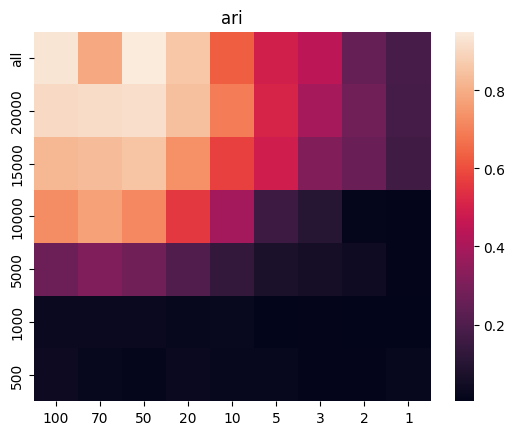

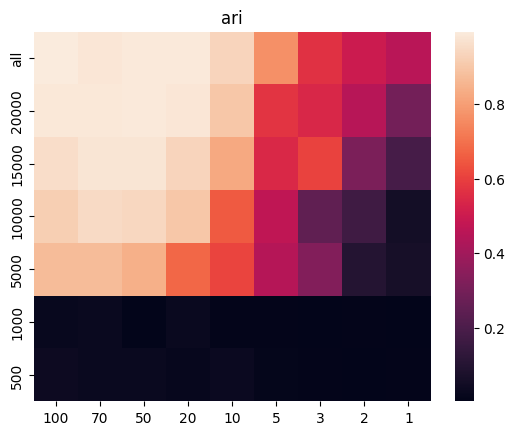

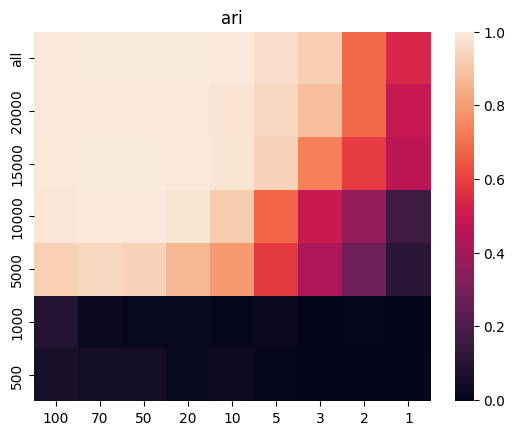

In [132]:
ari_all=create_condensed_dataframe(results_1,'ari')
plt.figure()
sns.heatmap(ari_all.astype(float))
plt.title('ari')
plt.figure()
ari_all=create_condensed_dataframe(results_2,'ari')
sns.heatmap(ari_all.astype(float))
plt.title('ari')
plt.figure()
ari_all=create_condensed_dataframe(results_3,'ari')
sns.heatmap(ari_all.astype(float))
plt.title('ari')

Text(0.5, 1.0, 'nmi')

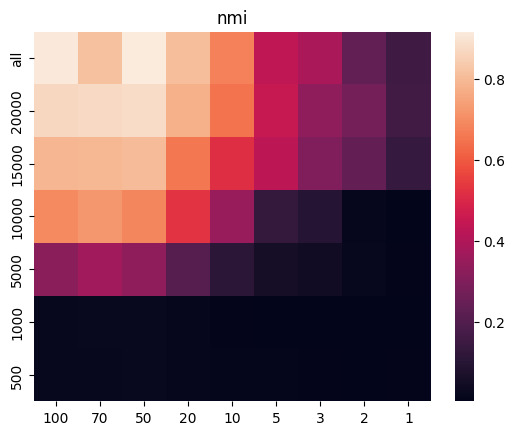

In [133]:
nmi_all=create_condensed_dataframe(results_1,'nmi')
sns.heatmap(nmi_all.astype(float))
plt.title('nmi')

Text(0.5, 1.0, 'AUC gains')

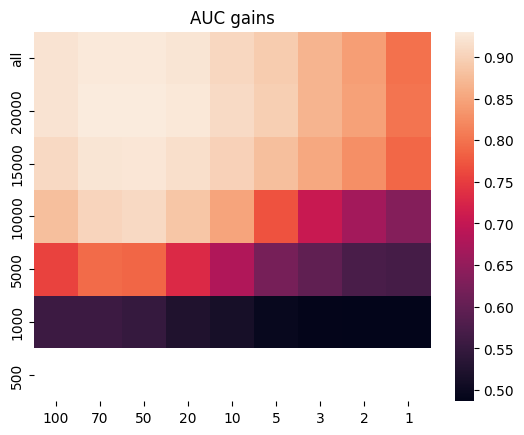

In [134]:
AUC_gains=create_condensed_dataframe(results_1,'AUC_gains')
sns.heatmap(AUC_gains.astype(float))
plt.title('AUC gains')

In [139]:
results_1

,type_of_sampling,experiment,n_genes,n_counts,mean_countsxcell,nmi,ari,F1score_all,F1score_gain,F1score_loss,AUC_loss,PR_gains,AUC_loss,PR_loss,AUC_gains,n_subsample
10,subsampled,01,all,70,25933.25,0.814561,0.784699,0.838174,0.898471,0.698708,0.779954,0.71482,0.779954,0.148164,0.927702,70
11,subsampled,01,20000,70,19246.542969,0.87118,0.911187,0.842185,0.901401,0.696957,0.779104,0.707544,0.779104,0.138385,0.930251,70
12,subsampled,01,15000,70,13707.869141,0.794897,0.833987,0.825026,0.891858,0.633884,0.742772,0.68863,0.742772,0.035224,0.921897,70
13,subsampled,01,10000,70,9028.750977,0.720474,0.770219,0.827466,0.870468,0.691977,0.776353,0.510719,0.776353,0.088926,0.903687,70
14,subsampled,01,5000,70,4137.347168,0.369652,0.309049,0.670047,0.719709,0.475041,0.651282,0.18774,0.651282,0.00884,0.791882,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,subsampled,01,500,2,13.373817,0.00702,0.008442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
116,subsampled,01,all,1,370.474762,0.156097,0.182428,0.570267,0.745453,0,0.516684,0.139096,0.516684,0.001851,0.797781,1
117,subsampled,01,10000,1,129.172714,0.005729,0.008676,0.383652,0.478476,0,0.521081,0.011851,0.521081,0.001415,0.633964,1
118,subsampled,01,5000,1,59.209778,0.007266,0.007198,0.27529,0.330276,0,0.512669,0.005716,0.512669,0.001391,0.567444,1


In [145]:
AUC_loss=create_condensed_dataframe(results_1,'AUC_loss')
sns.heatmap(AUC_loss.fillna(0).astype(float))
plt.title('AUC loss')

ValueError: Incompatible indexer with Series

In [111]:
results['number']=results['number'].astype(float)

In [112]:
results=results.sort_values(by='number')

In [118]:
results

,type_of_sampling,number,n_genes,mean_countsxcell,nmi,ari,F1score_all,F1score_gain,F1score_loss,ROC_gains,PR_gains,ROC_loss,PR_loss
5,counts,1.0,25691,370.474762,0.14273,0.138379,0.570136,0.745353,0,0.79772,0.141274,0.516716,0.001859
4,counts,5.0,25691,1852.374634,0.486211,0.536215,0.674683,0.86216,0.030624,0.892132,0.501135,0.518027,0.001855
3,counts,10.0,25691,3704.75,0.68555,0.634274,0.71301,0.877506,0.182385,0.90676,0.628777,0.556952,0.003039
2,counts,20.0,25691,7409.5,0.795845,0.84301,0.7857,0.894188,0.485729,0.922307,0.690137,0.665035,0.020321
1,counts,50.0,25691,18523.75,0.919954,0.950559,0.833743,0.899521,0.674899,0.928056,0.716165,0.76347,0.120775
0,counts,70.0,25691,25933.25,0.888086,0.919409,0.838957,0.899267,0.699427,0.928151,0.715456,0.780286,0.148895
6,counts,100.0,25691,37047.5,0.913175,0.93402,0.837737,0.890061,0.719302,0.920729,0.669057,0.792467,0.139218


Text(0.5, 0, 'Subsampled counts')

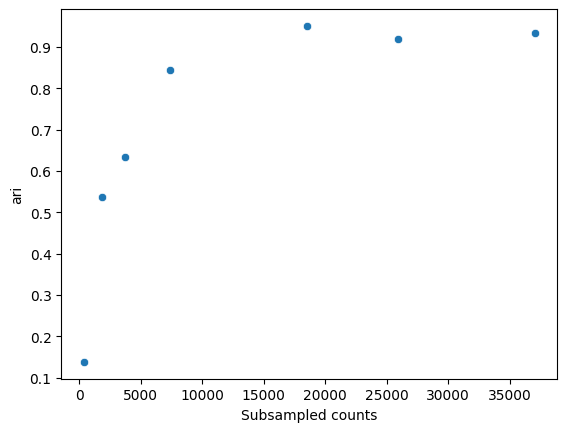

In [120]:
sns.scatterplot(data=results,x='mean_countsxcell',y='ari')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

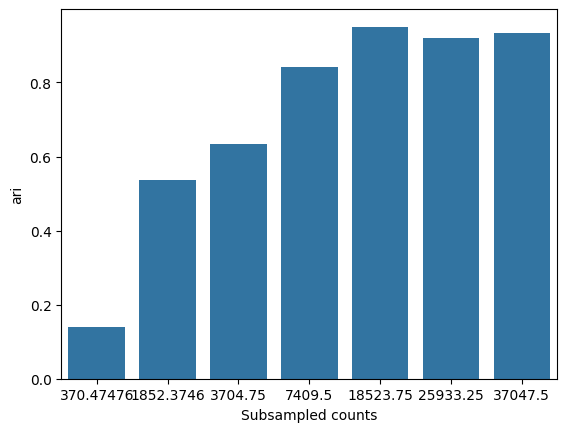

In [119]:
sns.barplot(data=results,x='number',y='ari')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

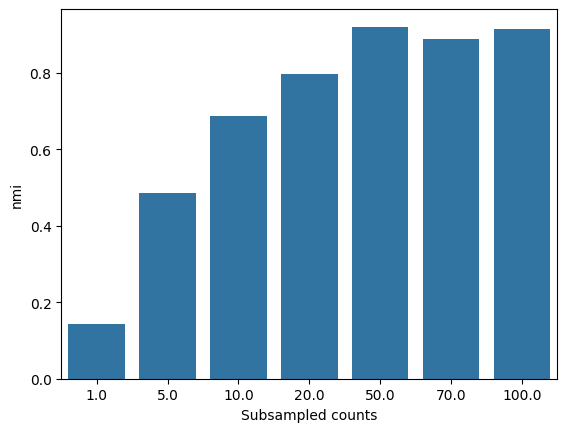

In [114]:
sns.barplot(data=results,x='number',y='nmi')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

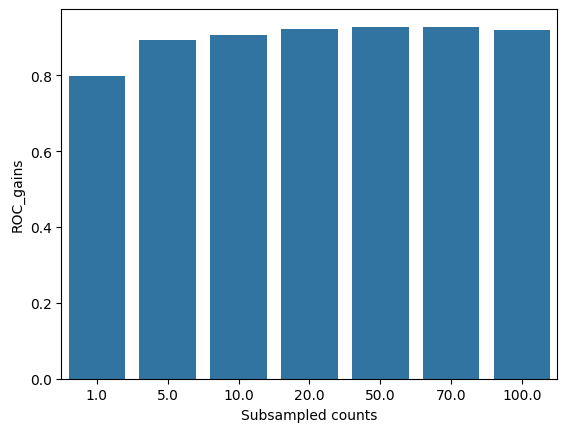

In [115]:
sns.barplot(data=results,x='number',y='AUC_gains')
plt.xlabel('Subsampled counts')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Subsampled counts')

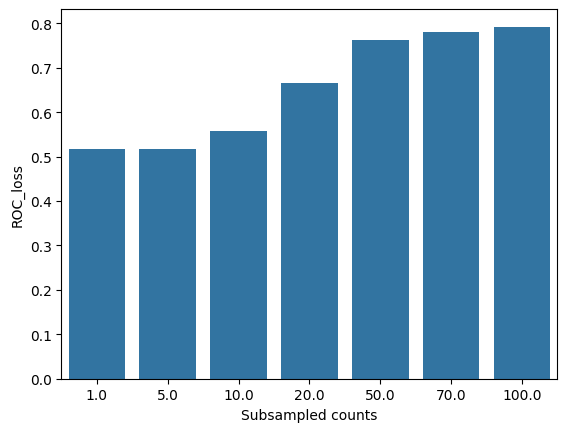

In [116]:
sns.barplot(data=results,x='number',y='AUC_loss')
plt.xlabel('Subsampled counts')

# Quantify on different number of genes

In [121]:
files=os.listdir(path_simulation)
processed_datasets=[f  for f in files if '_CNVinf' in f]
processed_datasets_genes=[f  for f in processed_datasets if 'genes' in f]

In [123]:
results=pd.DataFrame(columns=['type_of_sampling','number','n_genes','mean_countsxcell','nmi','ari','F1score_all','F1score_gain',
                      'F1score_loss','ROC_gains','PR_gains','ROC_loss','PR_loss'])
i=0
for file in processed_datasets_genes:
    print(file)
    type_of_subsampling=file.split('_')[3]
    number=file.split('_')[4]
    adata=sc.read(os.path.join(path_simulation,file))
    # clustering similarity metrics
    comp_key=[a for a in adata.obs.columns if 'cnv_leiden_res' in a]
    ari = icv.tl.compute_ari(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    nmi = icv.tl.compute_nmi(adata, reference_key='simulated_subclone', computed_key=comp_key[0])
    # CNV predictability metrics
    F1score_dict=compute_cnv_metrics(adata)
    ROC_PR_dict=compute_cnv_auc(adata)
    
    ## formatting them as CNVs
    results.loc[i,'type_of_subsampling']=type_of_subsampling
    results.loc[i,'number']=number
    results.loc[i,'n_genes']=adata.var.shape[0]
    results.loc[i,'mean_countsxcell']=np.mean(np.sum(adata.raw.X.todense(),axis=1))
    results.loc[i,'ari']=ari
    results.loc[i,'nmi']=nmi
    results.loc[i,'F1score_all']=F1score_dict['All']
    results.loc[i,'F1score_gain']=F1score_dict['Gain']
    results.loc[i,'F1score_loss']=F1score_dict['Loss']
    results.loc[i,'ROC_gains']=ROC_PR_dict['ROC AUC (Gains)']
    results.loc[i,'PR_gains']=ROC_PR_dict['PR AUC (Gains)']
    results.loc[i,'ROC_loss']=ROC_PR_dict['ROC AUC (Losses)']
    results.loc[i,'PR_loss']=ROC_PR_dict['PR AUC (Losses)']
    i=i+1

CNV_simulated_subsampled_genes_20000_CNVinf.h5ad
CNV_simulated_subsampled_genes_15000_CNVinf.h5ad
CNV_simulated_subsampled_genes_10000_CNVinf.h5ad
CNV_simulated_subsampled_genes_5000_CNVinf.h5ad
CNV_simulated_subsampled_genes_1000_CNVinf.h5ad
CNV_simulated_subsampled_genes_500_CNVinf.h5ad


ZeroDivisionError: division by zero

In [127]:
adata.layers['CNV_GT']

(1268, 500)

In [128]:
results

,type_of_sampling,number,n_genes,mean_countsxcell,nmi,ari,F1score_all,F1score_gain,F1score_loss,ROC_gains,PR_gains,ROC_loss,PR_loss,type_of_subsampling
0,NaN,20000,20000,36649.726562,0.86585,0.899906,0.837228,0.880649,0.734394,0.912566,0.61487,0.802043,0.110029,genes
1,NaN,15000,15000,36649.726562,0.761346,0.811618,0.803605,0.859413,0.647895,0.894559,0.543801,0.749478,0.027004,genes
2,NaN,10000,10000,36649.726562,0.657495,0.68681,0.798659,0.833538,0.686374,0.874251,0.332565,0.770927,0.033713,genes
3,NaN,5000,5000,36649.726562,0.293116,0.308157,0.614047,0.67975,0.348538,0.768242,0.077869,0.598268,0.003173,genes
4,NaN,1000,1000,36649.726562,0.005908,0.002708,0.295252,0.24001,0.268637,0.567799,0.002809,0.558521,0.003068,genes
